# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Нашей целью является построение модели, которая по фотографии определит приблизительный возраст человека на основе представленного набора фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
# general libraries
import numpy as np 
import pandas as pd 

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# color style
! pip install mplcyberpunk -q
import mplcyberpunk
plt.style.use('cyberpunk')

# set warning level
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Создадим функцию для гистограмм и ящиков с усами для количественных признаков.

def draw_graphs(df):
    num_col_names = df.select_dtypes(exclude='object').columns.tolist()
    for i in num_col_names:
        fig, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 6), sharex = True, gridspec_kw = {'height_ratios': (.9, .1)})
        sns.boxplot(x = df[i], ax = ax_hist)
        sns.histplot(data=df, x=i, kde=True, ax = ax_box, bins=100)
        ax_box.set(ylabel = 'Частота', title = f'Плотность распределения - {i}')
        ax_hist.set(xlabel = i)
        plt.xticks(ticks=range(0, df[i].max()+1, 5))
        plt.show()

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 7591 entries, 0 to 7590

Data columns (total 2 columns):

 #   Column     Non-Null Count  Dtype 

---  ------     --------------  ----- 

 0   file_name  7591 non-null   object

 1   real_age   7591 non-null   int64 

dtypes: int64(1), object(1)

memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


In [8]:
features, target = next(datagen_flow)

In [9]:
features.shape

(32, 224, 224, 3)

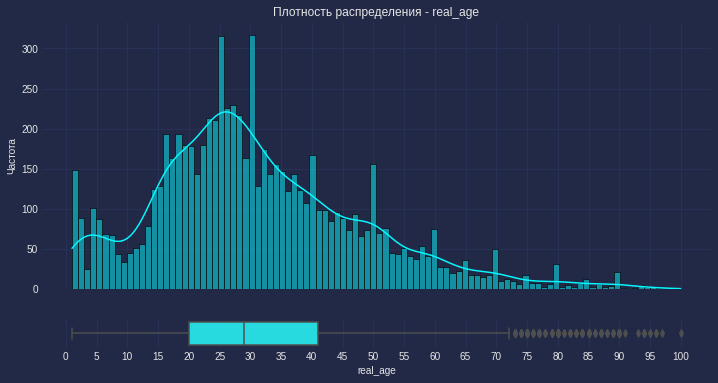

In [10]:
draw_graphs(labels)

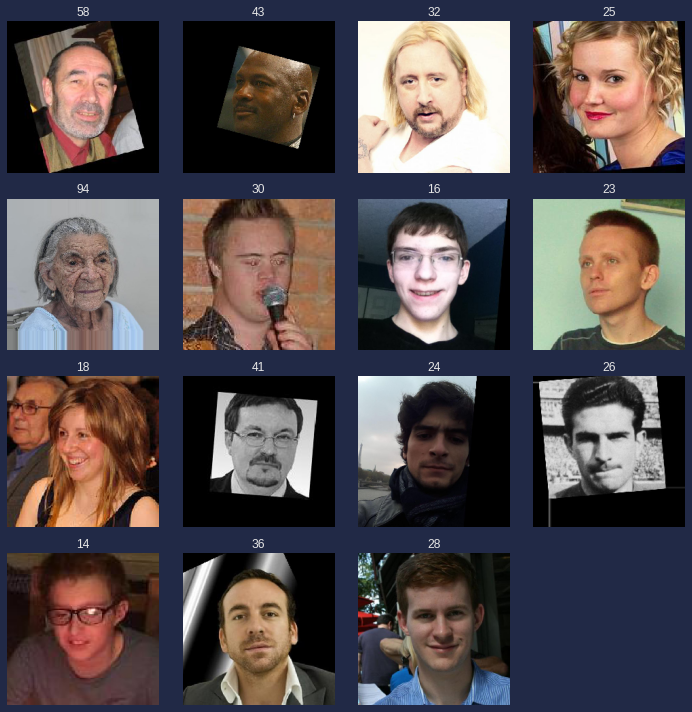

In [20]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Промежуточные выводы:
- датасет из 7591 изображений лиц и соответствующим реальным возрастом;
- пропуски отсутствуют;
- медианное значение возраста - 29 лет, среднее - 31.2 года;
- основная возрастная группа от 20 до 40 лет (судя по ящику с усами).

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import os
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)
    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return val_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs,
    steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)
    return model
```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 47s - loss: 235.1370 - mae: 10.9791 - val_loss: 870.5553 - val_mae: 24.6385
Epoch 2/10
178/178 - 39s - loss: 76.0378 - mae: 6.5970 - val_loss: 637.7932 - val_mae: 20.0041
Epoch 3/10
178/178 - 39s - loss: 50.1636 - mae: 5.3731 - val_loss: 214.1384 - val_mae: 10.9164
Epoch 4/10
178/178 - 39s - loss: 37.1957 - mae: 4.6423 - val_loss: 114.7907 - val_mae: 8.0491
Epoch 5/10
178/178 - 39s - loss: 28.2665 - mae: 4.0397 - val_loss: 72.7652 - val_mae: 6.4094
Epoch 6/10
178/178 - 39s - loss: 21.2473 - mae: 3.5536 - val_loss: 71.1175 - val_mae: 6.2949
Epoch 7/10
178/178 - 38s - loss: 17.5936 - mae: 3.2289 - val_loss: 63.6367 - val_mae: 6.0247
Epoch 8/10
178/178 - 41s - loss: 14.8669 - mae: 2.9507 - val_loss: 65.9084 - val_mae: 6.1274
Epoch 9/10
178/178 - 40s - loss: 11.9166 - mae: 2.6553 - val_loss: 67.9217 - val_mae: 6.3308
Epoch 10/10
178/178 - 40s - loss: 10.7728 - mae: 2.5101 - val_loss: 64.2051 - val_mae: 5.9634
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 64.2051 - mae: 5.9634
Test MAE: 5.9634
```

## Анализ обученной модели

В качестве аугментации выбрано горизонтальное отражение, число эпох - 10, learning rate оптимизатора Adam = 0.0001.
В результате удалось достичь хорошей метрики MAE - **5.96**.

Таким образом, модель может использоваться при предложении товаров соответствующим возрастным группам, но, учитывая, что модель ошибается на +- 6 лет, контроль добросовестности кассиров при продаже алкоголя не стоит в полной мере перекладывать на модель, а использовать ее как вспомогающую (например, выборочный контроль).